### De backtest class
Heeft een symbol van het aandeel om de data te vinden, maakt daar een dataframe van (tabel). Heeft verschillende methods met toepassing op de strategie/backtest, de eerste om de benodigde indicators te berekenen, de tweede method is om de koop/verkoop signalen te genereren door middel van masks die op hun beurt weer gebaseerd zijn op de verschillende indicatoren. Deze signalen genereren markeringen waarbij het signaal ofwel koop ofwel verkoop is, in de derde method worden dese koop en verkoop signalen met elkaar gekoppeld zodat er geen dubbele posities. Als er dus twee verkoop signalen achter elkaar zijn dan vervalt er dus 1. Als de strategie alleen long posities aangaat en het eerste signaal is een verkoop signaal waarna een koop signaal volgt dan vervalt het eerste signaal ook. De laatste method berekent de winst en andere benodigde gegevens om de prestaties van het algoritme te bepalen. Met deze backtest class kunnen ook strategieën die niet gebouwd zijn op technische indicatoren getest worden, de method voor het berekenen van de indicatoren en het bepalen van de signalen is dan anders.


In [1]:
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
from tiingo import TiingoClient

De numpy library zorgt ervoor dat we array's kunnen maken in plaats van python lists, deze nemen een stuk meer opslagruimte op omdat er allerlei informatie wordt opgeslagen die niet nodig is voor een lijst van getallen. Ook kan je met de numpy library goed met getallen werken. De pandas library is een van de belangrijkste bij het werken met veel data, het is de meest gebruikte library bij het werken met veel data in python. De ta library helpt ons met het berekenen van technische indicatoren, dit kunnen we zelf doen maar dit scheelt het invoeren van veel formules. Met de matplotlib library kunnen we mooi gegevens uit de data plotten. De laatste library die we gebruiken is de tiingo library, waarmee we de api van de historische data kunnen bedienen.

In [1]:
config = {}
config['session'] = True
config['api_key'] = 
#alpha vantage api key: 

client = TiingoClient(config)

SyntaxError: invalid syntax (2125196590.py, line 3)

In de bovenstaande code verbinden we met de api via onze api key. Vanaf nu kunnen we met de client (de verbinding met de api) met historische data werken.

In [17]:
class Backtest:
    
    def __init__(self, symbol):
        self.symbol = symbol
        frequency = "daily"
        data = client.get_ticker_price(symbol,
                                            fmt='json',
                                            startDate='2010-01-01',
                                            endDate='2022-6-1',
                                            frequency=frequency)
        self.df = pd.DataFrame(data)
        if self.df.empty:
            print("no data pulled")
        else:
            self.df['date'] = pd.to_datetime(self.df['date'])
            if frequency == 'daily':
                self.df['close'] = self.df['adjClose']
                self.df['open'] = self.df['adjOpen']
                self.df['high'] = self.df['adjHigh']
                self.df['low'] = self.df['adjLow']
            self.df.set_index('date', inplace=True)
            self.calc_indicators()
            self.generate_signals()
            self.match_signals()
            self.gains = self.calc_profit()
            self.cumul_gains = ((self.gains + 1).prod() - 1) * 100
            self.max_dd = self.gains.min() * 100
            self.plot_chart()

        
        
    def calc_indicators(self):
        self.df['ma_20'] = self.df.close.rolling(20).mean()
        self.df['ma_50'] = self.df.close.rolling(50).mean()
        self.df['ma_100'] = self.df.close.rolling(100).mean()
        self.df['volatility'] = self.df.close.rolling(20).std()
        self.df['upper_bb'] = self.df.ma_20 + (2 * self.df.volatility)
        self.df['lower_bb'] = self.df.ma_20 - (2 * self.df.volatility)
        self.df['rsi'] = ta.momentum.rsi(self.df.close, window=6)
        self.df['atr'] = ta.volatility.AverageTrueRange(high=self.df.high, low=self.df.low, close=self.df.close, window=14, fillna=False).average_true_range()
        self.df.dropna(inplace=True)
    
    def generate_signals(self):
        conditions = [(self.df.close < self.df.lower_bb), (self.df.close > self.df.upper_bb)]
        choices = ['Buy', 'Sell']
        self.df['signal'] = np.select(conditions, choices)
        self.df.signal = self.df.signal.shift()
        self.df.dropna(inplace=True)
    
    def match_signals(self):
        position = False
        buydates, selldates = [],[]
        
        for index, row in self.df.iterrows():
            if not position and row['signal'] == 'Buy':
                position = True
                buydates.append(index)
                buyprice = self.df.loc[index]['open']
                
            if position and row['signal'] == 'Sell':
                position = False
                selldates.append(index)
            # elif position and row['low'] < (buyprice - 0.5 * row['atr']):
            #     position = False
            #     idx = np.searchsorted(self.df.index, index)
            #     selldates.append(self.df.index[min(idx+1, len(self.df)-1)])
            # elif position and row['low'] > (buyprice + 2 * row['atr']):
            #     position = False
            #     idx = np.searchsorted(self.df.index, index)
            #     selldates.append(self.df.index[min(idx+1, len(self.df)-1)])
        
        self.buy_series = self.df.loc[buydates].open
        self.sell_series = self.df.loc[selldates].open
        
    def calc_profit(self):
        if self.buy_series.size > self.sell_series.size:
            self.buy_series = self.buy_series[:-1]
        return pd.DataFrame(data={'gains':(self.sell_series.values - self.buy_series.values)/self.buy_series.values, 'date': self.sell_series.index}).set_index('date')
    
    def plot_chart(self):
        account_start = 7.702180
        cumul_gains = []
        for i in range(self.gains.shape[0]):
            if i == 0:
                cumul_gains.append(self.gains['gains'][i] + 1)
            else:
                cumul_gains.append((self.gains['gains'][i] + 1) * cumul_gains[i-1])
        self.gains['cumul_gains'] = cumul_gains
        self.gains['account_value'] = self.gains['cumul_gains'] * account_start
        new_row = pd.DataFrame({'date':self.df.iloc[0].name, 'gains':1, 'cumul_gains':1, 'account_value':account_start}, index=[0]).set_index('date')
        self.gains = pd.concat([new_row, self.gains], ignore_index=False)
            

In [18]:
apple = Backtest("AAPL")

<AxesSubplot:xlabel='date'>

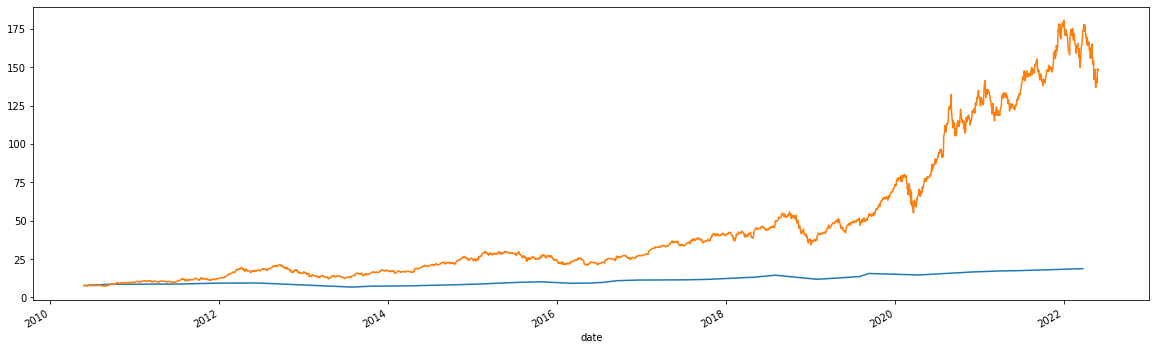

In [19]:
apple.gains["account_value"].plot(figsize=(20,6))
apple.df['close'].plot(figsize=(20,6))

In [20]:
apple.buy_series.size


30